<a href="https://colab.research.google.com/github/deepakkollala/CE888_Labs/blob/main/lab8/lab8_transferlearning_FT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/sagihaider/CE888_2021.git

Cloning into 'CE888_2021'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 381 (delta 120), reused 30 (delta 17), pack-reused 190
Receiving objects: 100% (381/381), 20.57 MiB | 52.78 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [ ]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/CE888_2021/Lab_8/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
base_dir = './'

In [ ]:
import os

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
pth = 'test'
os.mkdir('/content/'+pth+'/Humans')
os.mkdir('/content/'+pth+'/cats')
os.mkdir('/content/'+pth+'/dogs')
os.mkdir('/content/'+pth+'/horses')

pth = 'train'
os.mkdir('/content/'+pth+'/Humans')
os.mkdir('/content/'+pth+'/cats')
os.mkdir('/content/'+pth+'/dogs')
os.mkdir('/content/'+pth+'/horses')

In [ ]:
import pandas as pd
import shutil

def split_data(cls):
  flname = []
  fullpath = []
  strpath = './data/' + cls
  for filename in os.listdir(strpath):
      if filename.endswith("jpg"): 
        flname.append(filename)
        fullpath.append(strpath + '/' + filename)

  df = pd.DataFrame({'filename':flname, 'fullpath':fullpath })
  n_split = .7
  tot = len(fullpath)
  train_tot = round(len(fullpath) * n_split)
  test_tot = round(len(fullpath) * (1-n_split))

  train_df = df.iloc[:train_tot,:]
  test_df = df.iloc[train_tot:,:]

  for idx, row in train_df.iterrows():
    src = row['fullpath']
    dst = './train/' + cls + '/' + row['filename']
    print('train', src,dst)
    shutil.copyfile(src, dst)

  for idx, row in test_df.iterrows():
    src = row['fullpath']
    dst = './test/' + cls + '/' + row['filename']
    print('train', src,dst)
    shutil.copyfile(src, dst)

In [ ]:
split_data('Humans')
split_data('cats')
split_data('dogs')
split_data('horses')

In [ ]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import cv2
import numpy as np
from random import shuffle

In [ ]:
def label_img(img):
    #print('img', img)
    word_label = img.split('.')[0]
    #print('word_label', word_label)
    if word_label == 'Humans': return 0
    elif word_label == 'cats': return 1
    elif word_label == 'dogs': return 2
    elif word_label == 'horses': return 3

In [ ]:
IMG_SIZE = 150
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for f in os.listdir(datapath):
        label = label_img(f)
        #print(label)
        path = os.path.join(datapath, f)

        for img in os.listdir(path):
          ipath = os.path.join(path, img)
          #print(ipath)
          image = cv2.resize(cv2.imread(ipath), (IMG_SIZE, IMG_SIZE))
          image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

          X.append(np.array(image))
          y.append(label)

    return np.array(X), np.array(y)

In [ ]:
train_dir = '/content/train'
validation_dir = '/content/test'
test_dir= '/content/test'

In [ ]:
from keras.utils import to_categorical


train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)


train_y = to_categorical(train_y, 4)
val_y = to_categorical(val_y, 4)
test_y = to_categorical(test_y, 4)

In [ ]:
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop


base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='inceptionv3_model.h5', save_best_only=True),
]

In [ ]:
history = model.fit(train_X, train_y,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(val_X, val_y),
                               callbacks=my_callbacks)

Epoch 1/10
57/57 [==============================] - 51s 126ms/step - loss: 2.3403 - acc: 0.5312 - val_loss: 0.8628 - val_acc: 0.9016
Epoch 2/10
57/57 [==============================] - 4s 78ms/step - loss: 0.6265 - acc: 0.8318 - val_loss: 1.9947 - val_acc: 0.7951
Epoch 3/10
57/57 [==============================] - 4s 78ms/step - loss: 0.3676 - acc: 0.8953 - val_loss: 0.7458 - val_acc: 0.9016
Epoch 4/10
57/57 [==============================] - 4s 78ms/step - loss: 0.2918 - acc: 0.9131 - val_loss: 0.5658 - val_acc: 0.8934
Epoch 5/10
57/57 [==============================] - 4s 78ms/step - loss: 0.3633 - acc: 0.9100 - val_loss: 1.4138 - val_acc: 0.8566
Epoch 6/10
57/57 [==============================] - 4s 78ms/step - loss: 0.2744 - acc: 0.9205 - val_loss: 1.2996 - val_acc: 0.8320
Epoch 7/10
57/57 [==============================] - 4s 79ms/step - loss: 0.0571 - acc: 0.9865 - val_loss: 1.0140 - val_acc: 0.8648
Epoch 8/10
57/57 [==============================] - 4s 79ms/step - loss: 0.3094 -

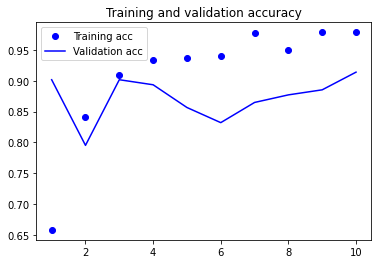

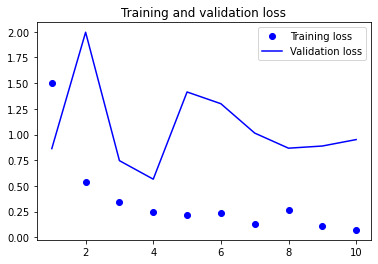

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred)

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.978723406791687
Val Accuracy:	 0.9139344096183777
Test Accuracy:	 0.9098360655737705
Precision:	 [0.89705882 0.89655172 0.87931034 0.98305085]
Recall:		 [1.         0.85245902 0.83606557 0.95081967]
F1 Score:	 [0.94573643 0.87394958 0.85714286 0.96666667]
AUC:		 0.9405737704918031
